<a href="https://colab.research.google.com/github/arnavdas88/Caffe-DeepDream/blob/master/DeepDream_Caffe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dreams (with Caffe)

This notebook demonstrates how to use the Caffe neural network framework to produce "dream" visuals shown in the Google Research blog post.

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with #deepdream so other researchers can check them out too.
Dependencies

This notebook is designed to have as few dependencies as possible:

    Standard Python scientific stack: NumPy, SciPy, PIL, IPython. Those libraries can also be installed as a part of one of the scientific packages for Python, such as Anaconda or Canopy.
    Caffe deep learning framework (installation instructions).
    Google protobuf library that is used for Caffe model manipulation.


In [0]:
!apt install caffe-cpu


# imports and basic notebook setup
from io import BytesIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    #print(a)
    PIL.Image.fromarray(a).save(f, fmt)
    display(PIL.Image.fromarray(a))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cpu is already the newest version (1.0.0-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# Loading DNN model

In this notebook we are going to use a GoogLeNet model trained on ImageNet dataset. Feel free to experiment with other models from Caffe Model Zoo. One particularly interesting model was trained in MIT Places dataset. It produced many visuals from the original blog post.


In [0]:
# Download the protobuf
!git clone https://github.com/BVLC/caffe

Cloning into 'caffe'...
remote: Enumerating objects: 65269, done.
remote: Total 65269 (delta 0), reused 0 (delta 0), pack-reused 65269
Receiving objects: 100% (65269/65269), 74.33 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (41267/41267), done.


In [0]:
# Download the caffe model
!wget http://dl.caffe.berkeleyvision.org/bvlc_googlenet.caffemodel

--2019-08-09 16:52:30--  http://dl.caffe.berkeleyvision.org/bvlc_googlenet.caffemodel
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53533754 (51M) [application/octet-stream]
Saving to: ‘bvlc_googlenet.caffemodel’

bvlc_googlenet.caff 100%[===================>]  51.05M  40.4MB/s    in 1.3s    

2019-08-09 16:52:31 (40.4 MB/s) - ‘bvlc_googlenet.caffemodel’ saved [53533754/53533754]



In [0]:
model_path = './caffe/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = './bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

# Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:

    offset image by a random jitter
    normalize the magnitude of gradient ascent steps
    apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:


In [0]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)


In [0]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in range(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print(octave, i, end, vis.shape)
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

# Download the images

In [0]:
!wget https://github.com/google/deepdream/raw/master/sky1024px.jpg
!wget https://github.com/google/deepdream/raw/master/flowers.jpg

--2019-08-09 17:00:19--  https://github.com/google/deepdream/raw/master/sky1024px.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/deepdream/master/sky1024px.jpg [following]
--2019-08-09 17:00:20--  https://raw.githubusercontent.com/google/deepdream/master/sky1024px.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65049 (64K) [image/jpeg]
Saving to: ‘sky1024px.jpg’

sky1024px.jpg       100%[===================>]  63.52K  --.-KB/s    in 0.02s   

2019-08-09 17:00:20 (3.98 MB/s) - ‘sky1024px.jpg’ saved [65049/65049]

--2019-08-09 17:00:23--  https://github.com/google/deepdream/raw/master/f

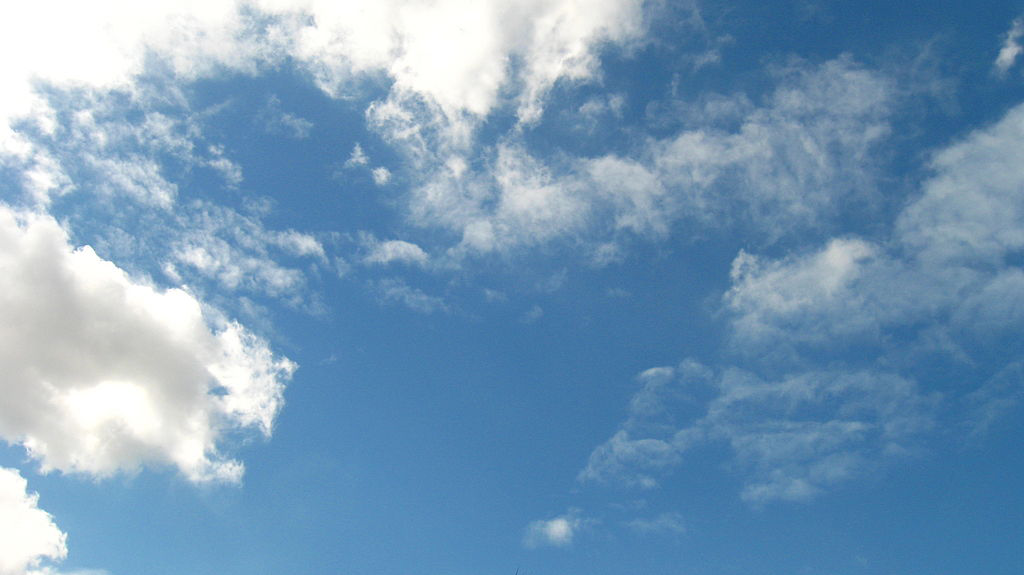

In [0]:
from PIL import Image
image = Image.open('./sky1024px.jpg', 'r')
img = np.float32(image)
#print(img)
showarray(img)

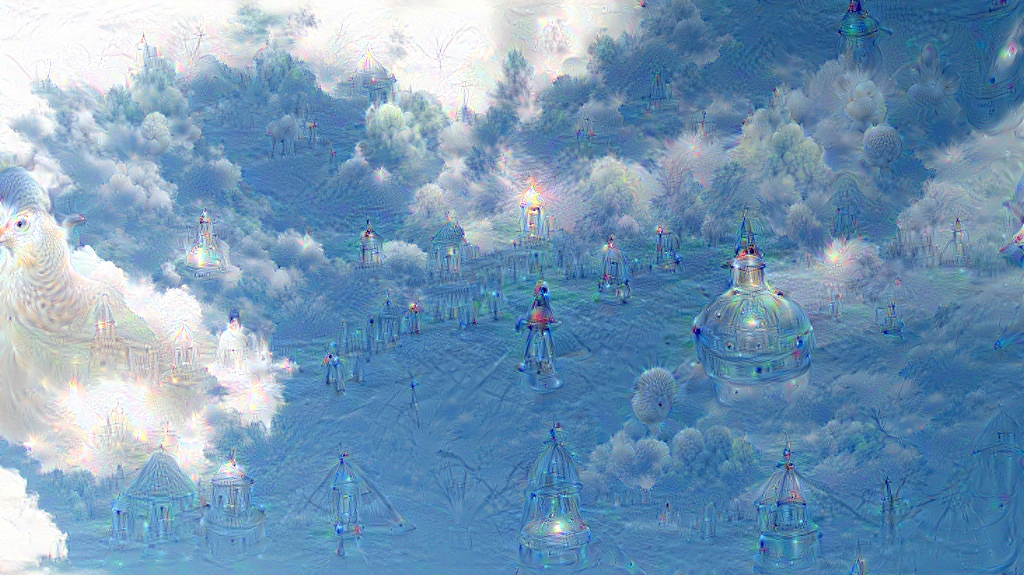

3 9 inception_4c/output (575, 1024, 3)


In [0]:
_=deepdream(net, img)


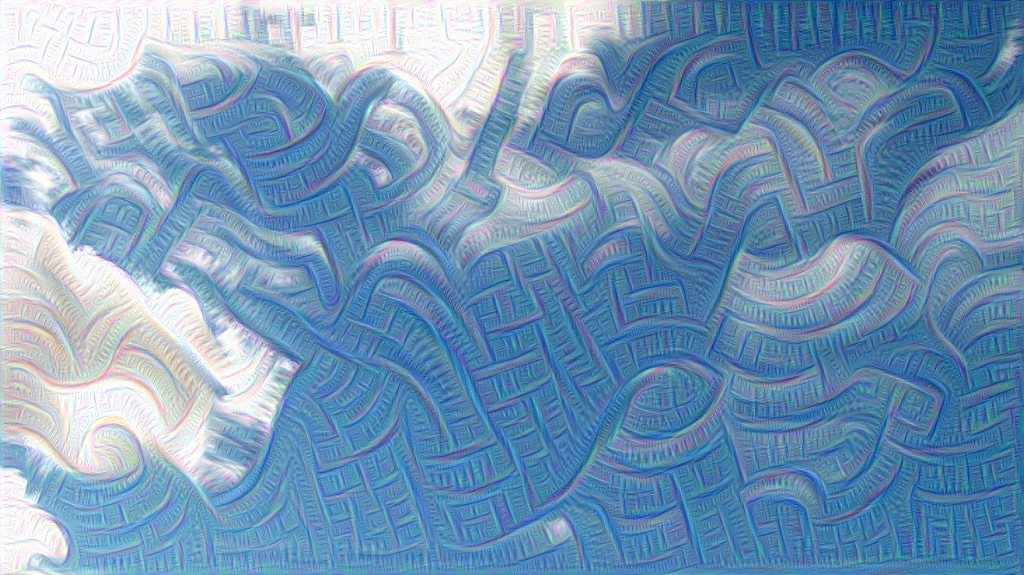

3 9 inception_3b/5x5_reduce (575, 1024, 3)


In [0]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

What if we feed the deepdream function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.


In [0]:
# The imidiate line below creates a directory named "frames". It is basically a shell command
!mkdir frames

frame = img
frame_i = 0

h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in range(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

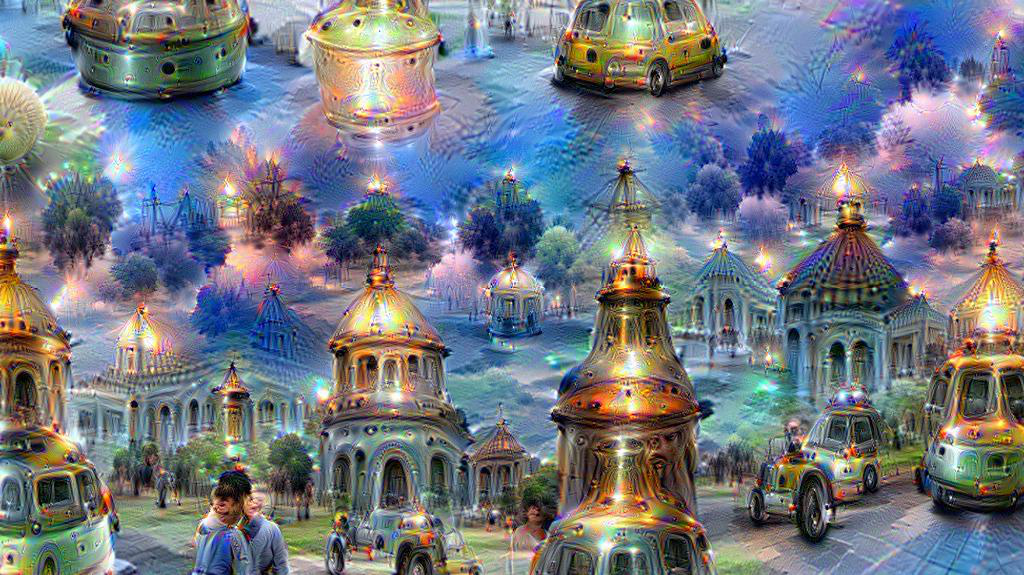

In [0]:
display(Image.open('frames/0029.jpg'))

#  Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "guide".


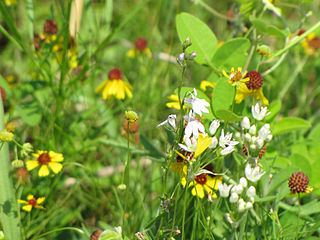

In [0]:
guide = np.float32(PIL.Image.open('flowers.jpg'))
showarray(guide)





Note that the neural network we use was trained on images downscaled to 224x224 size. So high resolution images might have to be downscaled, so that the network could pick up their features. The image we use here is already small enough.

Now we pick some target layer and extract guide image features.


In [0]:
end = 'inception_3b/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()



Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their best matching correspondences from the guide image.


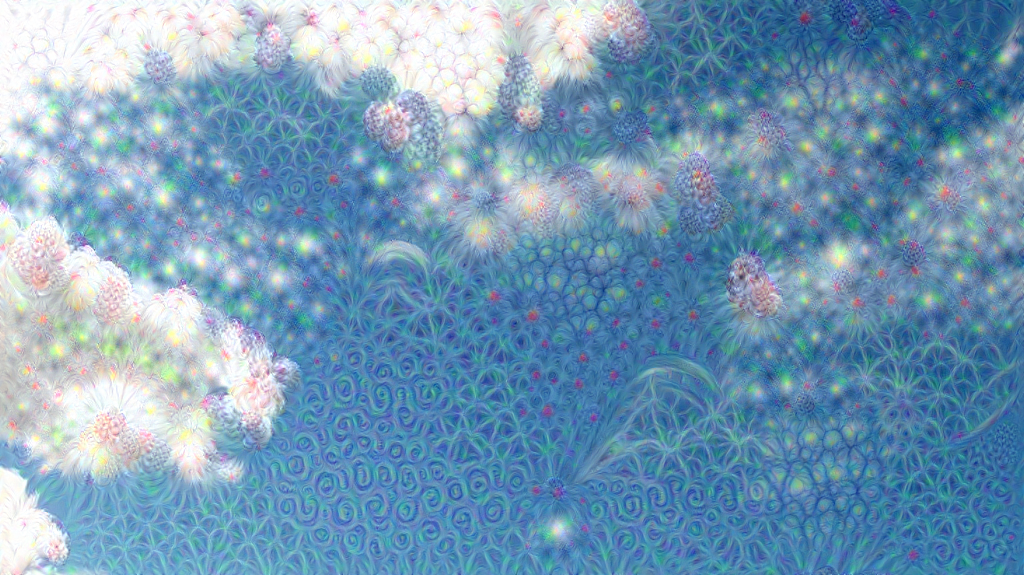

3 9 inception_3b/output (575, 1024, 3)


In [0]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

_=deepdream(net, img, end=end, objective=objective_guide)

